In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd drive

/content/drive


In [4]:
%cd 'My Drive'

/content/drive/My Drive


In [5]:
%cd 'UNet-cityscapes/'

/content/drive/My Drive/UNet-cityscapes


In [ ]:
!unzip archive.zip

In [11]:
import os

curr_dir = os.getcwd()
train = '/cityscapes_data/cityscapes_data/train/'
validation = '/cityscapes_data/cityscapes_data/val/'

images_train = os.listdir(curr_dir + train)
images_val = os.listdir(curr_dir + validation)

In [13]:
print('Total training images: ', len(images_train))
print('Total validation Images: ', len(images_val))

Total training images:  2975
Total validation Images:  500


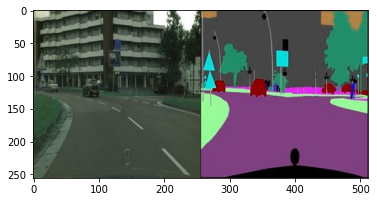

In [18]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

train_dir = curr_dir + train
val_dir = curr_dir + validation

img = cv2.imread(train_dir + images_train[0])
plt.imshow(img)

In [19]:
print("Image Shape: ",img.shape)

Image Shape:  (256, 512, 3)


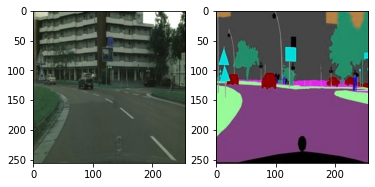

In [21]:
# Each image is of size 256 x 256.
x_train = img[:, :256]
y_train = img[:, 256:]
plt.subplot(121)
plt.imshow(x_train)
plt.subplot(122)
plt.imshow(y_train)

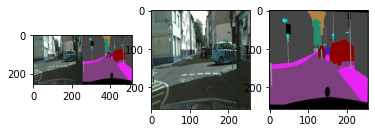

In [22]:
# Same Verification for Validation Dataset
imgval = cv2.imread(val_dir + images_val[0])
x_val = imgval[:, :256]
y_val = imgval[:, 256:]
plt.subplot(131)
plt.imshow(imgval)
plt.subplot(132)
plt.imshow(x_val)
plt.subplot(133)
plt.imshow(y_val)

In [23]:
# Split the data set for training and validation as input data (X) and output data (y). Sizing is done in accordance with the input and output parameters of UNet.
# Input Image: 572 x 572
# Output Image: 388 x 388


In [24]:
print(val_dir + images_val[0])

/content/drive/My Drive/UNet-cityscapes/cityscapes_data/cityscapes_data/val/1.jpg


In [26]:
%mkdir train_X
%mkdir train_y
%mkdir val_X
%mkdir val_y

In [ ]:
for imgtrain in images_train:
  img = cv2.imread(train_dir + imgtrain)
  x_train = img[:, :256]
  y_train = img[:, 256:]
  x_train = cv2.resize(x_train, (572, 572))
  y_train = cv2.resize(y_train, (388,388))
  cv2.imwrite(curr_dir + '/train_X/' + imgtrain, x_train)
  cv2.imwrite(curr_dir + '/train_y/' + imgtrain, y_train)


In [35]:
for imgvalid in images_val:
  img = cv2.imread(val_dir + imgvalid)
  x_val = img[:, :256]
  y_val = img[:, 256:]
  x_val = cv2.resize(x_val, (572, 572))
  y_val = cv2.resize(y_val, (388,388))
  cv2.imwrite(curr_dir + '/val_X/' + imgvalid, x_train)
  cv2.imwrite(curr_dir + '/val_y/' + imgvalid, y_train)

In [38]:
print(len(os.listdir(curr_dir + '/train_X')))
print(len(os.listdir(curr_dir + '/val_X')))
print(len(os.listdir(curr_dir + '/train_y')))
print(len(os.listdir(curr_dir + '/val_y')))

2975
500
2975
500


In [39]:
%mkdir test_X
%mkdir test_y

In [40]:
# The division of dataset has been divided as 2475 + 500 + 500 (training + validation + testing)
import random

images_test = random.sample(images_train, 500)

In [42]:
import shutil
for tests in images_test:
  shutil.move(curr_dir + '/train_X/' + tests, curr_dir + '/test_X/' + tests)
  shutil.move(curr_dir + '/train_y/' + tests, curr_dir + '/test_y/' + tests)

In [43]:
print(len(os.listdir(curr_dir + '/train_X')))
print(len(os.listdir(curr_dir + '/train_y')))
print(len(os.listdir(curr_dir + '/val_X')))
print(len(os.listdir(curr_dir + '/val_y')))
print(len(os.listdir(curr_dir + '/test_X')))
print(len(os.listdir(curr_dir + '/test_y')))

2475
2475
500
500
500
500


In [ ]:
# Now we have splitted the data, we have to specify the labels as well as make the dataset for PyTorch

